In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
pip install -U albumentations

     |████████████████████████████████| 102 kB 15.1 MB/s 
     |████████████████████████████████| 47.6 MB 73 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
#!pip install torchsummary
from torchsummary import summary
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import datetime as dt
import torch.optim as optim
import albumentations as A
from albumentations import (pytorch,HorizontalFlip,ToGray,ShiftScaleRotate,Normalize)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/Colab_Notebooks/model.py

Mounted at /content/drive


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [65]:
# With basic transformation
train_transform = transforms.Compose(
    [transforms.ToTensor()])
test_transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(type(trainset))
print(type(trainset.data))
print(len(trainset))
print(len(trainset.data))
#print((trainset[1]))

print(type(testset))
print(type(testset.data))
print(len(testset))
print(len(testset.data))

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'numpy.ndarray'>
50000
50000
<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'numpy.ndarray'>
10000
10000


In [6]:
# Gray Scale
# Creating new training set with augmented images

temp_new_trainset =[]
new_set = []

temp_new_testset =[]
new_set = []

train_transform_horizontal_flip = A.Compose(
    [
        A.HorizontalFlip()
    ]
)
train_transform_ShiftScaleRotate = A.Compose(
    [
        
        A.ShiftScaleRotate(rotate_limit=45)
    ]
)

train_transform_CoarseDropout = A.Compose(
    [
        
        A.CoarseDropout(max_holes = 1, max_height=16/32, max_width=16/32, min_holes = 1, 
        min_height=16/32, min_width=16/32, fill_value=.5, mask_fill_value = None)
    ]
)
for i in range (len(trainset)):
    sample = trainset[i] # get the first sample image and its label (This is a tuple of tensor and integer)
    sample_img , sample_lbl = sample
    converted_img = np.transpose(np.array(sample_img), (1, 2, 0))
    converted_img1 = torch.tensor(converted_img)
    converted_img1 = torch.permute(converted_img1,(2,0,1))
    
    #new_set = [converted_img1,sample_lbl]
    #temp_new_trainset.append(new_set)
    
    #print('MPP',converted_img.shape)
    
    
    gray_img = A.to_gray(converted_img)
    converted_img1 = torch.tensor(gray_img)
    converted_img1 = torch.permute(converted_img1,(2,0,1))
    new_set = [converted_img1,sample_lbl]
    temp_new_trainset.append(new_set)
    
    
    
    if (i%3 == 0):
      aug_img = train_transform_horizontal_flip(image = gray_img)['image']
      converted_img1 = torch.tensor(aug_img)
      converted_img1 = torch.permute(converted_img1,(2,0,1))
      new_set = [converted_img1,sample_lbl]
      temp_new_trainset.append(new_set)
      
    if (i%3 == 1):
      aug_img = train_transform_ShiftScaleRotate(image = gray_img)['image']
      converted_img1 = torch.tensor(aug_img)
      converted_img1 = torch.permute(converted_img1,(2,0,1))
      new_set = [converted_img1,sample_lbl]
      temp_new_trainset.append(new_set)
      
    
    #if (i%3 == 2):
    aug_img = train_transform_CoarseDropout(image = gray_img)['image']
    converted_img1 = torch.tensor(aug_img)
    converted_img1 = torch.permute(converted_img1,(2,0,1))
    new_set = [converted_img1,sample_lbl]
    temp_new_trainset.append(new_set)
    
for i in range (len(testset)):
    sample = testset[i] # get the first sample image and its label (This is a tuple of tensor and integer)
    sample_img , sample_lbl = sample
    converted_img = np.transpose(np.array(sample_img), (1, 2, 0))
    
        
    gray_img = A.to_gray(converted_img)
    converted_img1 = torch.tensor(gray_img)
    converted_img1 = torch.permute(converted_img1,(2,0,1))
    new_set = [converted_img1,sample_lbl]
    temp_new_testset.append(new_set)
 

In [66]:
for i in range (len(testset)):
    sample = testset[i] # get the first sample image and its label (This is a tuple of tensor and integer)
    sample_img , sample_lbl = sample
    converted_img = np.transpose(np.array(sample_img), (1, 2, 0))
    
        
    gray_img = A.to_gray(converted_img)
    converted_img1 = torch.tensor(gray_img)
    converted_img1 = torch.permute(converted_img1,(2,0,1))
    new_set = [converted_img1,sample_lbl]
    temp_new_testset.append(new_set)

In [67]:
# Normalize the test data
for i in range(len(temp_new_testset)):
    temp_new_testset[i][0] = (temp_new_testset[i][0] * test_std + test_mean)
print(len(temp_new_testset),'test images normalized')

70000 test images normalized


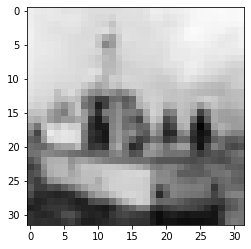

In [100]:
img = temp_new_testset[88][0]
converted_img = np.transpose(np.array(img), (1, 2, 0))
plt.imshow(converted_img)
plt.show()


In [68]:
testloader1 = torch.utils.data.DataLoader(temp_new_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [7]:
print(type(temp_new_trainset))
print(len(temp_new_trainset))
print(type(temp_new_trainset[0]))
print(type(temp_new_trainset[1]))
print(len(temp_new_trainset[0]))
print(len(temp_new_trainset[5]))
print ('-----------------------')
print(type(temp_new_trainset[0][0]))
print(type(temp_new_trainset[0][1]))
print ('-----------------------')
print(len(temp_new_trainset[0][0]))
print((temp_new_trainset[0][0].shape))

<class 'list'>
83334
<class 'list'>
<class 'list'>
2
2
-----------------------
<class 'torch.Tensor'>
<class 'int'>
-----------------------
3
torch.Size([3, 32, 32])


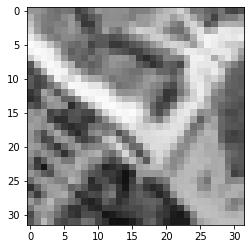

0.98511726
tensor(0.9851)


In [8]:
img = temp_new_trainset[3][0]
converted_img = np.transpose(np.array(img), (1, 2, 0))
plt.imshow(converted_img)
plt.show()
print(np.max(converted_img))
print(torch.max(img))

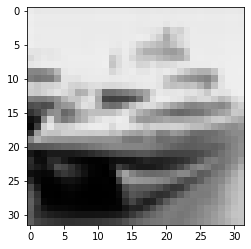

0.93850976
tensor(0.9385)


In [9]:
img = temp_new_testset[1][0]
converted_img = np.transpose(np.array(img), (1, 2, 0))
plt.imshow(converted_img)
plt.show()
print(np.max(converted_img))
print(torch.max(img))

torch.Size([32, 32, 3])


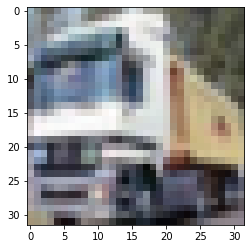

torch.Size([3, 32, 32])
tensor(0.0196)


In [10]:
sample = trainset[1]
sample_img , sample_lbl = sample
#plt.imshow(sample_img)
new_img = torch.permute(sample_img,(1,2,0))
print(new_img.shape)
plt.imshow(new_img)
plt.show()
print((sample_img.shape))
print(torch.min(sample_img))

In [11]:
train_images = torch.tensor
temp_tpl = ()
temp_lst = []
for i in range (len(temp_new_trainset)):
    temp_lst.append(temp_new_trainset[i][0])

temp_tpl = tuple(temp_lst)
train_images = torch.stack(temp_tpl)

test_images = torch.tensor
temp_tpl = ()
temp_lst = []
for i in range (len(temp_new_testset)):
    temp_lst.append(temp_new_testset[i][0])

temp_tpl = tuple(temp_lst)
test_images = torch.stack(temp_tpl)

In [12]:
print(train_images.shape)
mean = torch.mean(train_images)
std = train_images.std()

test_mean = torch.mean(test_images)
test_std = test_images.std()

print('Training dataset - mean:', mean)
print('Training dataset - std:', std)

print('--------------')

print('Test dataset - mean:', test_mean)
print('Test dataset - std:', test_std)

torch.Size([83334, 3, 32, 32])
Training dataset - mean: tensor(0.4807)
Training dataset - std: tensor(0.2386)
--------------
Test dataset - mean: tensor(0.4839)
Test dataset - std: tensor(0.2387)


In [13]:
# Normalize the training data
for i in range(len(temp_new_trainset)):
    temp_new_trainset[i][0] = (temp_new_trainset[i][0] - mean)/std
print(len(temp_new_trainset),'train images normalized')

83334 train images normalized


In [37]:
# Normalize the test data
for i in range(len(temp_new_testset)):
    temp_new_trainset[i][0] = (temp_new_trainset[i][0] - test_mean)/test_std
print(len(temp_new_testset),'test images normalized')

10000 test images normalized


In [51]:
batch_size = 24
SEED = 6
torch.manual_seed(SEED)
trainloader = torch.utils.data.DataLoader(temp_new_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(temp_new_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total number of images in the training dataset is -  83334
Type of dataset -  <class 'list'>
Type of image is -  torch.Size([3, 32, 32])
Type of label is -  <class 'int'>


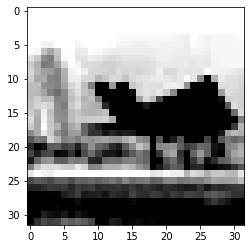

In [16]:
print('Total number of images in the training dataset is - ',len(temp_new_trainset)) 
print ('Type of dataset - ',type(temp_new_trainset))
#to_array_trainset = np.array(new_trainset)
sample = temp_new_trainset[8885] # get the first sample image and its label (This is a tuple of tensor and integer)
sample_img , sample_lbl = sample
print(f'Type of image is -  {sample_img.shape}')# Type of image is rank 3 tensor - 1x28x28
print(f'Type of label is -  {type(sample_lbl)}')# Type of label is integer
sample_img = sample_img * std + mean
plt.imshow((np.transpose(sample_img, (1, 2, 0))))
plt.show()


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.depthwise_separable_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, groups=3, padding=1, bias=False,dilation=1),
            nn.BatchNorm2d(3),
            #nn.Dropout(.05),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, bias=False),
            #nn.Dropout(.05),
            nn.BatchNorm2d(32),
            nn.Dropout(.05),
            nn.ReLU(),
        )
        
        
        self.depthwise_separable_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, groups=32, padding=1, dilation=1,
                      bias=False),
            nn.BatchNorm2d(32),
            #nn.Dropout(.10),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(.10),
            nn.ReLU(),
        )
        
        
        self.transposeconvblock = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False,
                               dilation=4),
            nn.BatchNorm2d(128),
            #nn.Dropout(.10),
            nn.ReLU(),

        )
        
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(3, 3), padding=0, bias=False, dilation=4),
            nn.BatchNorm2d(10),
            #nn.Dropout(.5),
            nn.ReLU()
        )
        
               
        
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=18))
        
        

    def forward(self, x):
        
        x = self.depthwise_separable_conv1(x)
        x = self.depthwise_separable_conv2(x)
        x = self.transposeconvblock(x)
        x = self.convblock(x)
        
               
        x = self.gap(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print ('The model parameters as below \n')
#summary(net, input_size=(3, 32, 32))

cuda
The model parameters as below 



In [18]:
print('New code\n')
l_start_time = dt.datetime.now()
print('Start Time - ',l_start_time)
print('Batch size = ', batch_size)
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
l_end_time = dt.datetime.now()
l_time_taken = l_end_time - l_start_time
print('End Time - ',l_end_time)
print('Time taken - ',l_time_taken)

New code

Start Time -  2021-11-15 17:13:44.266877
Batch size =  24
[1,   200] loss: 0.225
[1,   400] loss: 0.214
[1,   600] loss: 0.207
[1,   800] loss: 0.203
[1,  1000] loss: 0.200
[1,  1200] loss: 0.194
[1,  1400] loss: 0.190
[1,  1600] loss: 0.188
[1,  1800] loss: 0.186
[1,  2000] loss: 0.181
[1,  2200] loss: 0.179
[1,  2400] loss: 0.176
[1,  2600] loss: 0.176
[1,  2800] loss: 0.175
[1,  3000] loss: 0.173
[1,  3200] loss: 0.171
[1,  3400] loss: 0.170
[2,   200] loss: 0.165
[2,   400] loss: 0.164
[2,   600] loss: 0.163
[2,   800] loss: 0.161
[2,  1000] loss: 0.160
[2,  1200] loss: 0.159
[2,  1400] loss: 0.159
[2,  1600] loss: 0.155
[2,  1800] loss: 0.156
[2,  2000] loss: 0.154
[2,  2200] loss: 0.153
[2,  2400] loss: 0.150
[2,  2600] loss: 0.147
[2,  2800] loss: 0.147
[2,  3000] loss: 0.149
[2,  3200] loss: 0.145
[2,  3400] loss: 0.144
[3,   200] loss: 0.142
[3,   400] loss: 0.142
[3,   600] loss: 0.142
[3,   800] loss: 0.139
[3,  1000] loss: 0.140
[3,  1200] loss: 0.138
[3,  1400] l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog  frog  frog  bird


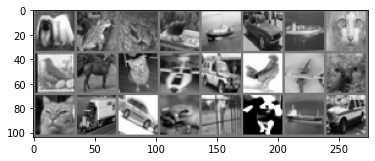

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img * std + mean     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  cat  ship  ship plane


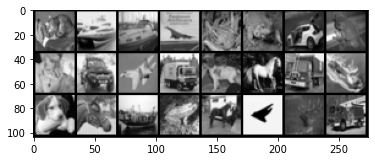

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show Test image


def testimshow(img):
    img = img       # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
testimshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Label -  cat


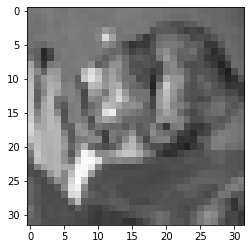

Label -  ship


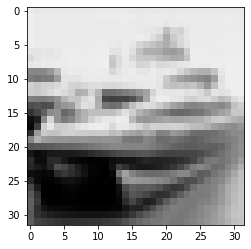

Label -  ship


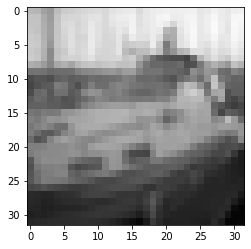

Label -  plane


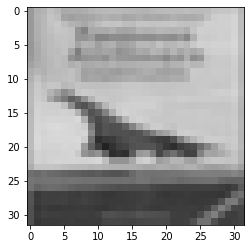

GroundTruth:    cat  ship  ship plane


In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
for i in range (4):
    print('Label - ',classes[labels[i]])
    testimshow(torchvision.utils.make_grid(images[i]))
    plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [110]:
print('New code\n')
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

New code

Predicted:   cat   ship   bird plane


In [104]:
print('New code\n')
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

New code

Accuracy of the network on the 10000 test images: 67 %


In [25]:
print('New code\n')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

New code

Accuracy of plane : 77 %
Accuracy of   car : 82 %
Accuracy of  bird : 51 %
Accuracy of   cat : 55 %
Accuracy of  deer : 67 %
Accuracy of   dog : 72 %
Accuracy of  frog : 70 %
Accuracy of horse : 75 %
Accuracy of  ship : 60 %
Accuracy of truck : 66 %
